# Running a ReCom Chain on Connecticut
* Set Up the chain
* @author Blayde Omura and Lisa Jurca
* AI for Redistricting final project on Connecticut

In [2]:
from gerrychain.random import random
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar
random.seed(12345678)

Create a directory that stores files for analysis

In [3]:
outdir="./CT_recom"

Here are parameters that we might change later

In [4]:
total_steps_in_run=500
save_district_graph_mod=1
save_district_plot_mod=100 # save every hundreth map

Import the graph 

In [7]:
os.makedirs(outdir, exist_ok=True)
ct_df = gpd.read_file("./CT/CT.shp")

print(ct_df.columns)

graph = Graph.from_geodataframe(ct_df)

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G16PREDCLI', 'G16PRERTRU',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSDBLU', 'G16USSRCAR',
       'G16USSLLIO', 'G16USSGRUS', 'G16USSOWRI', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP',
       'OTHERVAP', '2MOREVAP', 'CD', 'geometry'],
      dtype='object')


These are the elections we have available:

In [8]:
elections = [
    Election("SEN16", {"Democratic": "G16USSDBLU", "Republican": "G16USSRCAR"}),
    Election("PRES16", {"Democratic": "G16PREDCLI", "Republican": "G16PRERTRU"})
]

"TOT_POP" is the population column from our shapefile

In [9]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")} # updaters, need to keep total population

Election updaters, for computing election results using the vote totals from our shapefile.

In [10]:
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

Create the partition

In [11]:
initial_partition = GeographicPartition(graph, 
                                        assignment= "CD", 
                                        updaters=my_updaters)

The ReCom proposal needs to know the ideal population for the districts so that we can improve speed by bailing early on unbalanced partitions.

In [12]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition) # total pop / num districts

Create a proposal

In [13]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,  # can change to 5%
                   node_repeats=2
                  )

In [14]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [15]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

Create the markov chain

In [16]:
chain = MarkovChain( # markov chain
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=total_steps_in_run
    )

## Signature of Gerrymandering - MARGINAL BOX PLOTS

In [17]:
# data frame that keeps track of percent democratic and sort it
data = pd.DataFrame(
    sorted(partition["SEN16"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

  0%|          | 0/500 [00:00<?, ?it/s]

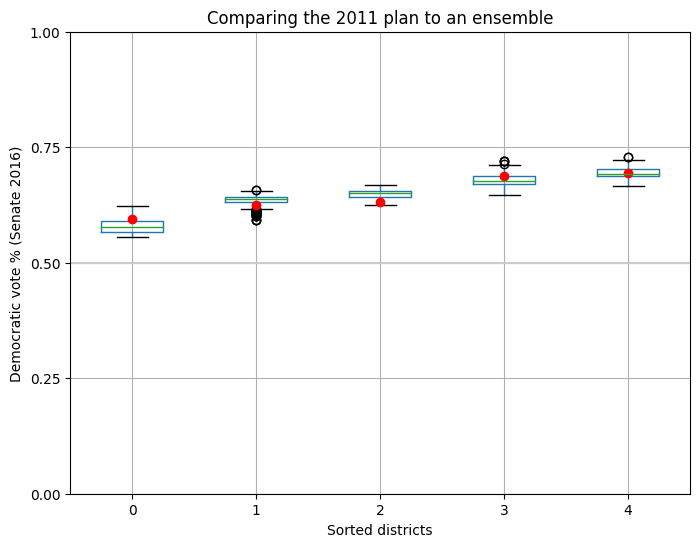

In [18]:
# makes box plots look reasonable
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

## Creating output files
- Here we'll create some output files for each of our maps.
- For each graph, we have one csv with the partisan (election outcome) data, and one csv with the district dual graph data.
- We're also outputting the map every 100 steps.

In [23]:
# df=gpd.read_file("./CT/CT.shp")

In [24]:
# index_output_file = outdir + "_index.csv"

In [26]:
# with open(index_output_file, mode='w') as index_file:
#     index_writer = csv.writer(index_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
#     #Run through chain, building 
#     for t, part in enumerate(chain):
#         if t%save_district_graph_mod==0:
#             tmp_str=str(t)
#             file_prefix=tmp_str.rjust(8,'0')
            
#             #Add file names to index file            
#             edges_output_file = outdir + file_prefix + "_edges.csv"
#             districts_output_file = outdir + file_prefix + "_districts.csv"            
#             index_writer.writerow(["./" + file_prefix + "_districts.csv", "./" + file_prefix + "_edges.csv"])
                        

#             #Build the district graph and write edges to file    
#             s=set()
#             for e in part["cut_edges"]:
#                 s.add( (part.assignment[e[0]],part.assignment[e[1]] ))
#                 #s.add( (e[0],e[1]) )
                
#             with open(edges_output_file, mode='w') as edges_file:
#                 edges_writer = csv.writer(edges_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
#                 for e1 in s:
#                     edges_writer.writerow([e1[0],e1[1]])
               
            
#             #Build the district file that contains election results
#             D_votes = part["SEN16"].votes("Democratic") 
#             R_votes = part["SEN16"].votes("Republican") 
           
#             with open(districts_output_file, mode='w') as districts_file:            
#                 districts_writer = csv.writer(districts_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
#                 for i in range(len(D_votes)):
#                     districts_writer.writerow([i+1, int(D_votes[i]),int(R_votes[i]),0])
             
#         if t%save_district_plot_mod==0:
#             df.plot(pd.Series([part.assignment[i] for i in df.index]), cmap="tab20", figsize=(16,8))
#             #plt.show()
#             plot_output_file = outdir + file_prefix + "_plot.png"
#             plt.savefig(plot_output_file)
            # plt.close()